## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [2]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

In [3]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Let's prepare our data. We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [5]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [7]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/kaggle/working/class_indices.json

## Training


In [8]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


We now create a small upstream model on top of the MobileNet using the functional API

In [9]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [10]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [11]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/25


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5535: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "categorical_crossentropy"


150/150 [==============================] - 264s 2s/step - loss: 1.9759 - categorical_accuracy: 0.4883 - accuracy: 0.4883 - val_loss: 0.7578 - val_categorical_accuracy: 0.8172 - val_accuracy: 0.8172
Epoch 2/25
150/150 [==============================] - 257s 2s/step - loss: 0.7689 - categorical_accuracy: 0.7923 - accuracy: 0.7923 - val_loss: 0.4915 - val_categorical_accuracy: 0.8634 - val_accuracy: 0.8634
Epoch 3/25
150/150 [==============================] - 257s 2s/step - loss: 0.5521 - categorical_accuracy: 0.8408 - accuracy: 0.8408 - val_loss: 0.3923 - val_categorical_accuracy: 0.8891 - val_accuracy: 0.8891
Epoch 4/25
150/150 [==============================] - 256s 2s/step - loss: 0.4557 - categorical_accuracy: 0.8648 - accuracy: 0.8648 - val_loss: 0.3461 - val_categorical_accuracy: 0.8963 - val_accuracy: 0.8963
Epoch 5/25
150/150 [==============================] - 256s 2s/step - loss: 0.4025 - categorical_accuracy: 0.8798 - accuracy: 0.8798 - val_loss: 0.3015 - val_categorical_accura

## Review the training process

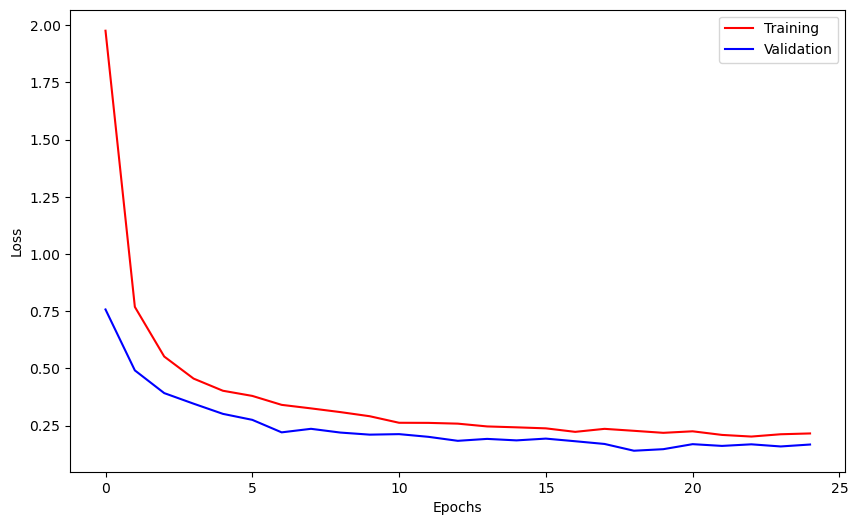

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

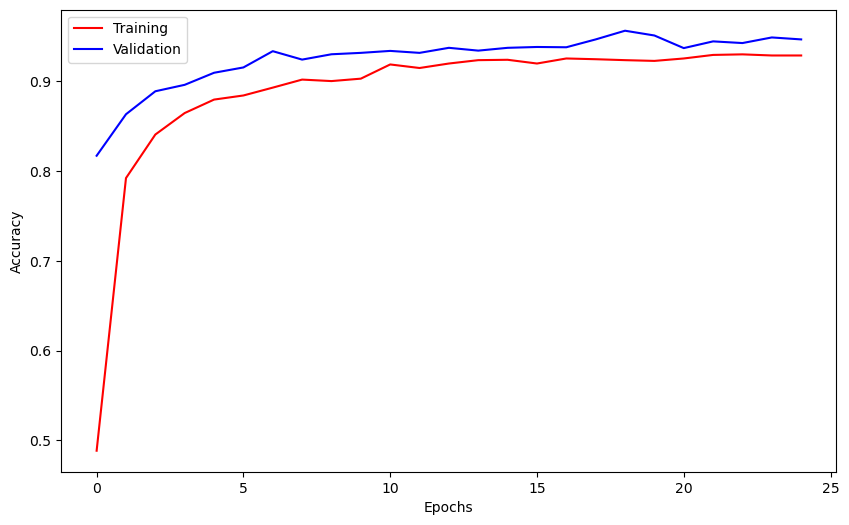

In [13]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model
We finally save the model in the standard TensorFlow 2 SavedModel format.

In [14]:
model.save('plant_disease')

## Converting to tflite Model

In [15]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)